In [1]:
import numpy as np
import helper as h
import matplotlib.pyplot as plt
from visclassifier import visclassifier

Recall that the we can express the solution as a linear combination of the training examples $ \{\phi(\mathbf{x}_1), \cdots, \phi(\mathbf{x}_n) \}$:
$$
    \begin{aligned}
    \mathbf{w} = \sum_{j = 1}^n \alpha_j y_j \phi(\mathbf{x}_j)
    \end{aligned}
$$

To simplify, we define $\beta_j = \alpha_j y_j$ and we can express the solution as: 
$$
    \begin{aligned}
    \mathbf{w} = \sum_{j = 1}^n \beta_j \phi(\mathbf{x}_j)
    \end{aligned}
$$

If we substitute the formulation above into our unconstrained regularized squared hinge loss, 
$$
    \begin{aligned}
    \min_{\mathbf{w},b}\underbrace{\mathbf{w}^T\mathbf{w}}_{l_{2} \text{ regularizer} } +  C\  \sum_{i=1}^{n}\underbrace{\max\left [ 1-y_{i}(\mathbf{w}^T \mathbf{x}_i+b),0 \right ] ^2}_{ \text{squared hinge loss} }
    \end{aligned}
$$

we obtain: 

$$
\begin{aligned}
       \underbrace{\sum_{i = 1} ^n \sum_{j = 1}^n \beta_i  \beta_j \phi(\mathbf{x} _i)^T \phi(\mathbf{x}_j)}_{l_{2} \text{ regularizer}} +  C\  \sum_{i=1}^{n}\underbrace{\max\left [ 1-y_{i}(\sum_{j = 1}^n \beta_j \phi(\mathbf{x}_j)^T \phi(\mathbf{x}_i)+b),0 \right ] ^ 2}_{\text{squared hinge loss}}     
\end{aligned}
$$
Now, if we replace all the $\phi(\mathbf{x} _i)^T \phi(\mathbf{x}_j)$ with $k(\mathbf{x}_i, \mathbf{x}_j)$, we obtained the "kernelized" hinge loss. 

$$
\begin{aligned}
      \min_{\beta_1,\cdots,\beta_n, b} \underbrace{\sum_{i = 1} ^n \sum_{j = 1}^n \beta_i \beta_j k(\mathbf{x} _i, \mathbf{x}_j)}_{l_{2} \text{ regularizer}} +  C\  \sum_{i=1}^{n}\underbrace{\max\left [ 1-y_{i}(\sum_{j = 1}^n \beta_j k(\mathbf{x}_j, \mathbf{x}_i)+b),0 \right ] ^ 2}_{\text{squared hinge loss}}
\end{aligned}
$$

The expression above seems a little bit unweildy, so we are going to simplify the expression again. First, we will simplfy the $l_{2}$ regularizer. Define $\mathbf{\beta} = [\beta_1, \cdots, \beta_n]^T$ and $K_{train}$ to be the kernel matrix calculated on the training set, namely, the (i, j)-th entry of $K_{train}$ is $k(\mathbf{x} _i, \mathbf{x}_j)$. It is easy to verify that the $l_{2}$ regularizer can be expressed as the quadratic form  

$$
    \sum_{i = 1} ^n \sum_{j = 1}^n \beta_i \beta_j k(\mathbf{x} _i, \mathbf{x}_j) = \mathbf{\beta}^T K_{train} \mathbf{\beta}
$$

Now, let's simplify the squared hinge loss. To start, we define $K_{train}[i]$ as the i-th row of $k_{train}$ expressed as a column vector. Now, the summation term within the hinge loss can be expressed as: 

$$
    \sum_{ j = 1}^n \beta_j k(\mathbf{x}_j, \mathbf{x}_i) = \mathbf{\beta}^T K_{train}[i]
$$

Combining the two simplifications we have, we arrive at: 
$$
\begin{aligned}
      \min_{\mathbf{\beta}, b} \underbrace{\mathbf{\beta}^T k_{train} \mathbf{\beta}}_{l_{2}  \text{ regularizer}} +  C\  \sum_{i=1}^{n}\underbrace{\max\left [ 1-y_{i}(\mathbf{\beta}^T K_{train}[i]+b),0 \right ] ^ 2}_{\text{squared hinge loss}}
\end{aligned}
$$
Note that the loss function we have above is very similar to the vanilla linear SVM, the differences are: 

1. Instead of $\mathbf{w}$, we have $\mathbf{\beta}$
2. The $l_{2}$ regularizer $\mathbf{w}^T \mathbf{w} = \mathbf{w}^T I \mathbf{w}$ is changed to $\mathbf{\beta}^T k_{train} \mathbf{\beta}$ to account for using $\mathbf{\beta}$ instead of $\mathbf{w}$
3. The inner product $\mathbf{w}^T \mathbf{x}_i$ in the hinge loss is changed to $\mathbf{\beta}^T K_{train}[i]$

Before we start, let's generate some data and visualize the training set. We are going to use the linear separable data that we used in our previous project!

<IPython.core.display.Javascript object>


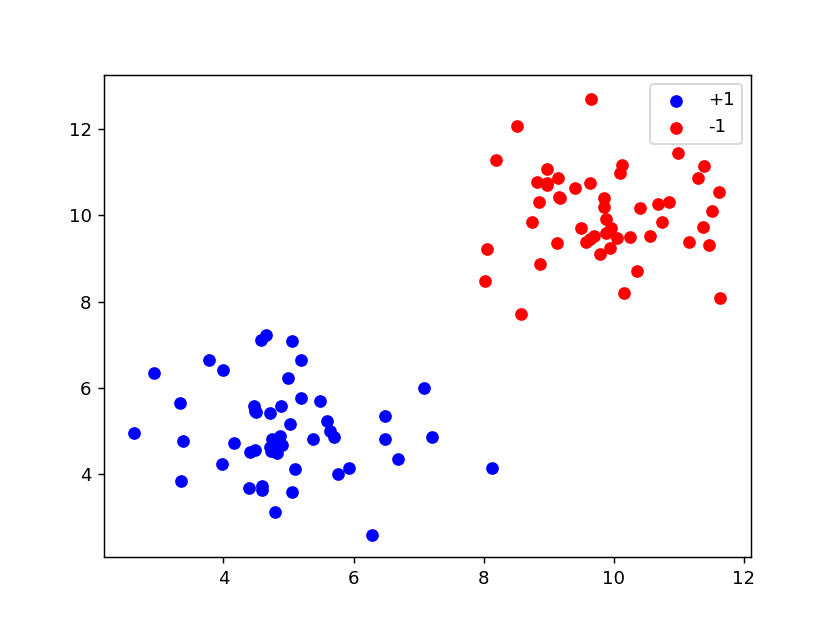

In [15]:
%matplotlib notebook
xTr,yTr = h.generate_data()
h.visualize_2D(xTr, yTr)

In this assignment, you need to implement three functions <code>computeK</code> that computes the kernel function efficiently, <code>loss</code> that calculates the unconstrained kernelized hinge loss and <code>grad</code> that calculates the gradient of the loss with respect to $\mathbf{\beta}, b$

In <code>computeK</code>, you are going to calcuate the values of different kernel functions. Note that when calculating the rbf kernel, you can use the <code>h.l2distance(X, Z)</code> functions to calculate the pairwise l2 distance efficiently.

In [41]:
def computeK(kerneltype, X, Z, kpar=1):
    """
    function K = computeK(kernel_type, X, Z)
    computes a matrix K such that Kij=k(x,z);
    for three different function linear, rbf or polynomial.
    
    Input:
    kerneltype: either 'linear','polynomial','rbf'
    X: n input vectors of dimension d (nxd);
    Z: m input vectors of dimension d (mxd);
    kpar: kernel parameter (inverse kernel width gamma in case of RBF, degree in case of polynomial)
    
    OUTPUT:
    K : nxm kernel matrix
    """
    assert kerneltype in ["linear","polynomial","rbf"], "Kernel type %s not known." % kerneltype
    assert X.shape[1] == Z.shape[1], "Input dimensions do not match"
    
    K = None
    
    ## BEGIN SOLUTION
    if kerneltype == "linear":
        K = X.dot(Z.T)
    elif kerneltype == "polynomial":
        K = np.power((X.dot(Z.T) + 1), kpar)
    elif kerneltype =='rbf':
        K = np.exp(-kpar*np.square(h.l2distance(X,Z)))
    else:
        raise ValueError('Invalid Kernel Type!')
    ## END SOLUTION
    return K

In [65]:
# These tests test whether your computeK() is implemented correctly

xTr_test, yTr_test = h.generate_data(100)
xTr_test2, yTr_test2 = h.generate_data(50)
n, d = xTr_test.shape

# Checks whether computeK compute the kernel matrix with the right dimension
def computeK_test1():
    s1 = (computeK('rbf', xTr_test, xTr_test2, kpar=1).shape == (100, 50))
    s2 = (computeK('polynomial', xTr_test, xTr_test2, kpar=1).shape == (100, 50))
    s3 = (computeK('linear', xTr_test, xTr_test2, kpar=1).shape == (100, 50))
    return (s1 and s2 and s3)

# Checks whether the kernel matrix is symmetric
def computeK_test2():
    k_rbf = computeK('rbf', xTr_test, xTr_test, kpar=1)
    s1 = np.allclose(k_rbf, k_rbf.T)
    k_poly = computeK('polynomial', xTr_test, xTr_test, kpar=1)
    s2 = np.allclose(k_poly, k_poly.T)
    k_linear = computeK('linear', xTr_test, xTr_test, kpar=1)
    s3 = np.allclose(k_linear, k_linear.T)
    return (s1 and s2 and s3)

# Checks whether the kernel matrix is positive semi-definite
def computeK_test3():
    k_rbf = computeK('rbf', xTr_test2, xTr_test2, kpar=1)
    eigen_rbf = np.linalg.eigvals(k_rbf)
    eigen_rbf[np.isclose(eigen_rbf, 0)] = 0
    s1 = np.all(eigen_rbf >= 0)
    k_poly = computeK('polynomial', xTr_test2, xTr_test2, kpar=1)
    eigen_poly = np.linalg.eigvals(k_poly)
    eigen_poly[np.isclose(eigen_poly, 0)] = 0
    s2 = np.all(eigen_poly >= 0)
    k_linear = computeK('linear', xTr_test2, xTr_test2, kpar=1)
    eigen_linear = np.linalg.eigvals(k_linear)
    eigen_linear[np.isclose(eigen_linear, 0)] = 0
    s3 = np.all(eigen_linear >= 0)
    return (s1 and s2 and s3)

# Checks whether computeK compute the right kernel matrix with rbf kernel
def computeK_test4():
    k = computeK('rbf', xTr_test, xTr_test2, kpar=1)
    k2 = h.computeK_grader('rbf', xTr_test, xTr_test2, kpar=1)
    
    return np.linalg.norm(k - k2) < 1e-5

# Checks whether computeK compute the right kernel matrix with polynomial kernel
def computeK_test5():
    k = computeK('polynomial', xTr_test, xTr_test2, kpar=1)
    k2 = h.computeK_grader('polynomial', xTr_test, xTr_test2, kpar=1)
    
    return np.linalg.norm(k - k2) < 1e-5

# Checks whether computeK compute the right kernel matrix with linear kernel
def computeK_test6():
    k = computeK('linear', xTr_test, xTr_test2, kpar=1)
    k2 = h.computeK_grader('linear', xTr_test, xTr_test2, kpar=1)
    
    return np.linalg.norm(k - k2) < 1e-5


h.runtest(computeK_test1, 'computeK_test1')
h.runtest(computeK_test2, 'computeK_test2')
h.runtest(computeK_test3, 'computeK_test3')
h.runtest(computeK_test4, 'computeK_test4')
h.runtest(computeK_test5, 'computeK_test5')
h.runtest(computeK_test5, 'computeK_test6')

Running Test: computeK_test1 ... ✔ Passed!
Running Test: computeK_test2 ... ✔ Passed!
Running Test: computeK_test3 ... ✔ Passed!
Running Test: computeK_test4 ... ✔ Passed!
Running Test: computeK_test5 ... ✔ Passed!
Running Test: computeK_test6 ... ✔ Passed!


In [66]:
# Autograder test cell - worth 1 point
# runs computeK_test1
### BEGIN HIDDEN TESTS

xTr_test, yTr_test = h.generate_data(100)
xTr_test2, yTr_test2 = h.generate_data(50)
n, d = xTr_test.shape

# Checks whether computeK compute the kernel matrix with the right dimension
s1 = (computeK('rbf', xTr_test, xTr_test2, kpar=1).shape == (100, 50))
s2 = (computeK('polynomial', xTr_test, xTr_test2, kpar=1).shape == (100, 50))
s3 = (computeK('linear', xTr_test, xTr_test2, kpar=1).shape == (100, 50))
assert (s1 and s2 and s3)

### END HIDDEN TESTS

In [67]:
# Autograder test cell - worth 1 point
# runs computeK_test2
### BEGIN HIDDEN TESTS

xTr_test, yTr_test = h.generate_data(100)
xTr_test2, yTr_test2 = h.generate_data(50)
n, d = xTr_test.shape

# Checks whether the kernel matrix is symmetric
k_rbf = computeK('rbf', xTr_test, xTr_test, kpar=1)
s1 = np.allclose(k_rbf, k_rbf.T)
k_poly = computeK('polynomial', xTr_test, xTr_test, kpar=1)
s2 = np.allclose(k_poly, k_poly.T)
k_linear = computeK('linear', xTr_test, xTr_test, kpar=1)
s3 = np.allclose(k_linear, k_linear.T)
assert (s1 and s2 and s3)

### END HIDDEN TESTS

In [68]:
# Autograder test cell - worth 1 point
# runs computeK_test3
### BEGIN HIDDEN TESTS

xTr_test, yTr_test = h.generate_data(100)
xTr_test2, yTr_test2 = h.generate_data(50)
n, d = xTr_test.shape

k_rbf = computeK('rbf', xTr_test2, xTr_test2, kpar=1)
eigen_rbf = np.linalg.eigvals(k_rbf)
eigen_rbf[np.isclose(eigen_rbf, 0)] = 0
s1 = np.all(eigen_rbf >= 0)
k_poly = computeK('polynomial', xTr_test2, xTr_test2, kpar=1)
eigen_poly = np.linalg.eigvals(k_poly)
eigen_poly[np.isclose(eigen_poly, 0)] = 0
s2 = np.all(eigen_poly >= 0)
k_linear = computeK('linear', xTr_test2, xTr_test2, kpar=1)
eigen_linear = np.linalg.eigvals(k_linear)
eigen_linear[np.isclose(eigen_linear, 0)] = 0
s3 = np.all(eigen_linear >= 0)
assert (s1 and s2 and s3)

### END HIDDEN TESTS

In [69]:
# Autograder test cell - worth 1 point
# runs computeK_test4
### BEGIN HIDDEN TESTS

xTr_test, yTr_test = h.generate_data(100)
xTr_test2, yTr_test2 = h.generate_data(50)
n, d = xTr_test.shape

# Checks whether computeK compute the right kernel matrix with rbf kernel
k = computeK('rbf', xTr_test, xTr_test2, kpar=1)
k2 = h.computeK_grader('rbf', xTr_test, xTr_test2, kpar=1)

assert np.linalg.norm(k - k2) < 1e-5

### END HIDDEN TESTS

In [ ]:
# Autograder test cell - worth 1 point
# runs computeK_test5
### BEGIN HIDDEN TESTS

xTr_test, yTr_test = h.generate_data(100)
xTr_test2, yTr_test2 = h.generate_data(50)
n, d = xTr_test.shape

# Checks whether computeK compute the right kernel matrix with rbf kernel
k = computeK('polynomial', xTr_test, xTr_test2, kpar=1)
k2 = h.computeK_grader('polynomial', xTr_test, xTr_test2, kpar=1)

assert np.linalg.norm(k - k2) < 1e-5

### END HIDDEN TESTS

In [ ]:
# Autograder test cell - worth 1 point
# runs computeK_test5
### BEGIN HIDDEN TESTS

xTr_test, yTr_test = h.generate_data(100)
xTr_test2, yTr_test2 = h.generate_data(50)
n, d = xTr_test.shape

# Checks whether computeK compute the right kernel matrix with rbf kernel
k = computeK('linear', xTr_test, xTr_test2, kpar=1)
k2 = h.computeK_grader('linear', xTr_test, xTr_test2, kpar=1)

assert np.linalg.norm(k - k2) < 1e-5

### END HIDDEN TESTS

Now, you are going to implement the <code>loss</code>. Note that the function signature of this function is slightly different from the previous assignment. Previously, we can pass in $\mathbf{w}$ to calculate the loss values. However, in the kernelized version of the loss, $\mathbf{w}$ is calculated as the linear combination of the training examples, so we need to pass the training set to the function. 

In [4]:
def loss(beta, b, xTr, yTr, xTe, yTe, C, kerneltype, kpar=1):
    """
    INPUT:
    beta : n dimensional vector that stores the linear combination coefficient
    xTr   : nxd dimensional matrix (training set, each row is an input vector)
    yTr   : n   dimensional vector (training label, each entry is a label)
    b     : scalar (bias)
    xTe   : mxd dimensional matrix (test set, each row is an input vector)
    yTe   : m dimensional vector (test label, each entry is a label)
    C     : scalar (constant that controls the tradeoff between l2-regularizer and hinge-loss)
    kerneltype: either 'linear','polynomial','rbf'
    kpar  : kernel parameter (inverse kernel width gamma in case of RBF, degree in case of polynomial)
    
    OUTPUTS:
    loss     : the total loss obtained with (alpha, xTr, yTr, b) on xTe and yTe (scalar)
    """
    
    loss_val = 0.0
    # compute the kernel values between xTr and xTr 
    kernel_train = computeK(kerneltype, xTr, xTr, kpar)
    # compute the kernel values between xTe and xTr
    kernel_test = computeK(kerneltype, xTe, xTr, kpar)
    
    ### BEGIN SOLUTION
    prediction = kernel_test @ beta  + b
    margin = yTe * prediction
    
    loss_val = beta @ kernel_train @ beta + C*(np.sum(np.maximum(1 - margin, 0) ** 2))
    ### END SOLUTION
    return loss_val

In [5]:
# These tests test whether your loss() is implemented correctly

xTr_test, yTr_test = h.generate_data()
n, d = xTr_test.shape

# Check whether your loss() returns a scalar
def loss_test1():
    beta = np.zeros(n)
    b = np.zeros(1)
    loss_val = loss(beta, b, xTr_test, yTr_test, xTr_test, yTr_test, 10, 'rbf')
    
    return np.isscalar(loss_val)


# Check whether your loss() returns a nonnegative scalar
def loss_test2():
    beta = np.random.rand(n)
    b = np.random.rand(1)
    loss_val = loss(beta, b, xTr_test, yTr_test, xTr_test, yTr_test, 10, 'rbf')
    
    return loss_val >= 0

# Check whether you implement l2-regularizer correctly
def loss_test3():
    beta = np.random.rand(n)
    b = np.random.rand(1)
    loss_val = loss(beta, b, xTr_test, yTr_test, xTr_test, yTr_test, 0, 'rbf')
    loss_val_grader = h.loss_grader(beta, b, xTr_test, yTr_test, xTr_test, yTr_test, 0, 'rbf')
    
    return (np.linalg.norm(loss_val - loss_val_grader) < 1e-5)

loss_test3()

# Check whether you implement square hinge loss correctly
def loss_test4():
    beta = np.zeros(n)
    b = np.random.rand(1)
    loss_val = loss(beta, b, xTr_test, yTr_test, xTr_test, yTr_test, 10, 'rbf')
    loss_val_grader = h.loss_grader(beta, b, xTr_test, yTr_test, xTr_test, yTr_test, 10, 'rbf')
    
    return (np.linalg.norm(loss_val - loss_val_grader) < 1e-5)

# Check whether you implement square hinge loss correctly
def loss_test5():
    beta = np.zeros(n)
    b = np.random.rand(1)
    loss_val = loss(beta, b, xTr_test, yTr_test, xTr_test, yTr_test, 10, 'rbf')
    loss_val_grader = h.loss_grader(beta, b, xTr_test, yTr_test, xTr_test, yTr_test, 10, 'rbf')
    
    return (np.linalg.norm(loss_val - loss_val_grader) < 1e-5)

# Check whether you implement loss correctly
def loss_test6():
    beta = np.zeros(n)
    b = np.random.rand(1)
    loss_val = loss(beta, b, xTr_test, yTr_test, xTr_test, yTr_test, 100, 'rbf')
    loss_val_grader = h.loss_grader(beta, b, xTr_test, yTr_test, xTr_test, yTr_test, 100, 'rbf')
    
    return (np.linalg.norm(loss_val - loss_val_grader) < 1e-5)

h.runtest(loss_test1,'loss_test1')
h.runtest(loss_test2,'loss_test2')
h.runtest(loss_test3,'loss_test3')
h.runtest(loss_test4,'loss_test4')
h.runtest(loss_test5,'loss_test5')
h.runtest(loss_test6,'loss_test6')

Running Test: loss_test1 ... ✔ Passed!
Running Test: loss_test2 ... ✔ Passed!
Running Test: loss_test3 ... ✔ Passed!
Running Test: loss_test4 ... ✔ Passed!
Running Test: loss_test5 ... ✔ Passed!
Running Test: loss_test6 ... ✔ Passed!


In [18]:
# Autograder test cell - worth 1 point
# runs loss_test1
### BEGIN HIDDEN TESTS

xTr_test, yTr_test = h.generate_data()
n, d = xTr_test.shape

beta = np.zeros(n)
b = np.zeros(1)
loss_val = loss(beta, b, xTr_test, yTr_test, xTr_test, yTr_test, 10, 'rbf')
    
assert np.isscalar(loss_val)
### END HIDDEN TESTS

In [20]:
# Autograder test cell - worth 1 point
# runs loss test2
### BEGIN HIDDEN TESTS

xTr_test, yTr_test = h.generate_data()
n, d = xTr_test.shape

beta = np.random.rand(n)
b = np.random.rand(1)
loss_val = loss(beta, b, xTr_test, yTr_test, xTr_test, yTr_test, 10, 'rbf')
    
assert loss_val >= 0
### END HIDDEN TESTS

In [22]:
# Autograder test cell - worth 1 point
# runs loss test3
### BEGIN HIDDEN TESTS

xTr_test, yTr_test = h.generate_data()
n, d = xTr_test.shape

beta = np.random.rand(n)
b = np.random.rand(1)
loss_val = loss(beta, b, xTr_test, yTr_test, xTr_test, yTr_test, 0, 'rbf')
loss_val_grader = h.loss_grader(beta, b, xTr_test, yTr_test, xTr_test, yTr_test, 0, 'rbf')
    
assert (np.linalg.norm(loss_val - loss_val_grader) < 1e-5)
### END HIDDEN TESTS

In [23]:
# Autograder test cell - worth 1 point
# runs loss test4
### BEGIN HIDDEN TESTS

xTr_test, yTr_test = h.generate_data()
n, d = xTr_test.shape

beta = np.zeros(n)
b = np.random.rand(1)
loss_val = loss(beta, b, xTr_test, yTr_test, xTr_test, yTr_test, 10, 'rbf')
loss_val_grader = h.loss_grader(beta, b, xTr_test, yTr_test, xTr_test, yTr_test, 10, 'rbf')

assert (np.linalg.norm(loss_val - loss_val_grader) < 1e-5)

### END HIDDEN TESTS

In [24]:
# Autograder test cell - worth 1 point
# runs loss test5
### BEGIN HIDDEN TESTS

xTr_test, yTr_test = h.generate_data()
n, d = xTr_test.shape

beta = np.zeros(n)
b = np.random.rand(1)
loss_val = loss(beta, b, xTr_test, yTr_test ,xTr_test, yTr_test, 10, 'rbf')
loss_val_grader = h.loss_grader(beta, b, xTr_test, yTr_test, xTr_test, yTr_test, 10, 'rbf')

assert (np.linalg.norm(loss_val - loss_val_grader) < 1e-5)
### END HIDDEN TESTS

In [25]:
# Autograder test cell - worth 1 point
# runs loss test6
### BEGIN HIDDEN TESTS

xTr_test, yTr_test = h.generate_data()
n, d = xTr_test.shape

beta = np.zeros(n)
b = np.random.rand(1)
loss_val = loss(beta, b, xTr_test, yTr_test, xTr_test, yTr_test, 100, 'rbf')
loss_val_grader = h.loss_grader(beta, b, xTr_test, yTr_test, xTr_test, yTr_test, 100, 'rbf')
    
assert (np.linalg.norm(loss_val - loss_val_grader) < 1e-5)

### END HIDDEN TESTS

In [6]:
def grad(beta, b, xTr, yTr, xTe, yTe, C, kerneltype, kpar=1):
    """
    INPUT:
    beta : n dimensional vector that stores the linear combination coefficient
    xTr   : nxd dimensional matrix (training set, each row is an input vector)
    yTr   : n   dimensional vector (training label, each entry is a label)
    b     : scalar (bias)
    xTe   : mxd dimensional matrix (test set, each row is an input vector)
    yTe   : m dimensional vector (test label, each entry is a label)
    C     : scalar (constant that controls the tradeoff between l2-regularizer and hinge-loss)
    kerneltype: either 'linear','polynomial','rbf'
    kpar  : kernel parameter (inverse kernel width gamma in case of RBF, degree in case of polynomial)
    
    
    OUTPUTS:
    beta_grad :  n dimensional vector (the gradient of the hinge loss with respect to the alphas)
    bgrad :  constant (the gradient of he hinge loss with respect to the bias, b)
    """
    
    n, d = xTr.shape
    
    beta_grad = np.zeros(n)
    bgrad = np.zeros(1)
    
    # compute the kernel values between xTr and xTr 
    kernel_train = computeK(kerneltype, xTr, xTr, kpar)
    # compute the kernel values between xTe and xTr
    kernel_test = computeK(kerneltype, xTe, xTr, kpar)
    
    ### BEGIN SOLUTION
    prediction = kernel_test @ beta + b
    margin = yTe * prediction
    
    hinge = np.maximum(1 - margin, 0)
    indicator = ((1 - margin) > 0).astype(int)
    
    beta_grad = 2 * (kernel_train @ (beta)) + C * np.sum((2 * hinge * indicator * -yTe).reshape(-1, 1) * kernel_test, axis=0) 
    bgrad = C * np.sum(2 * hinge * indicator * - yTe, axis=0)
    
    ### END SOLUTION
    return beta_grad, bgrad

In [33]:
# These tests test whether your grad() is implemented correctly

xTr_test, yTr_test = h.generate_data()
n, d = xTr_test.shape

# Checks whether grad returns a tuple
def grad_test1():
    beta = np.random.rand(n)
    b = np.random.rand(1)
    out = grad(beta, b, xTr_test, yTr_test, xTr_test, yTr_test, 10, 'rbf')
    return len(out) == 2

# Checks the dimension of gradients
def grad_test2():
    beta = np.random.rand(n)
    b = np.random.rand(1)
    beta_grad, bgrad = grad(beta, b, xTr_test, yTr_test, xTr_test, yTr_test, 10, 'rbf')
    return len(beta_grad) == n and np.isscalar(bgrad)

# Checks the gradient of the l2 regularizer
def grad_test3():
    beta = np.random.rand(n)
    b = np.random.rand(1)
    beta_grad, bgrad = grad(beta, b, xTr_test, yTr_test, xTr_test, yTr_test, 0, 'rbf')
    beta_grad_grader, bgrad_grader = h.grad_grader(beta, b, xTr_test, yTr_test, xTr_test, yTr_test, 0, 'rbf')
    return (np.linalg.norm(beta_grad - beta_grad_grader) < 1e-5) and \
        (np.linalg.norm(bgrad - bgrad_grader) < 1e-5)

# Checks the gradient of the square hinge loss
def grad_test4():
    beta = np.zeros(n)
    b = np.random.rand(1)
    beta_grad, bgrad = grad(beta, b, xTr_test, yTr_test, xTr_test, yTr_test, 1, 'rbf')
    beta_grad_grader, bgrad_grader = h.grad_grader(beta, b, xTr_test, yTr_test, xTr_test, yTr_test, 1, 'rbf')
    return (np.linalg.norm(beta_grad - beta_grad_grader) < 1e-5) and \
        (np.linalg.norm(bgrad - bgrad_grader) < 1e-5)

# Checks the gradient of the loss
def grad_test5():
    beta = np.random.rand(n)
    b = np.random.rand(1)
    beta_grad, bgrad = grad(beta, b, xTr_test, yTr_test, xTr_test, yTr_test, 10, 'rbf')
    beta_grad_grader, bgrad_grader = h.grad_grader(beta, b, xTr_test, yTr_test, xTr_test, yTr_test, 10, 'rbf')
    return (np.linalg.norm(beta_grad - beta_grad_grader) < 1e-5) and \
        (np.linalg.norm(bgrad - bgrad_grader) < 1e-5)

h.runtest(grad_test1, 'grad_test1')
h.runtest(grad_test2, 'grad_test2')
h.runtest(grad_test3, 'grad_test3')
h.runtest(grad_test4, 'grad_test4')
h.runtest(grad_test5, 'grad_test5')

Running Test: grad_test1 ... ✔ Passed!
Running Test: grad_test2 ... ✔ Passed!
Running Test: grad_test3 ... ✔ Passed!
Running Test: grad_test4 ... ✔ Passed!
Running Test: grad_test5 ... ✔ Passed!


In [35]:
# Autograder test cell - worth 1 point
# runs grad test1
### BEGIN HIDDEN TESTS

xTr_test, yTr_test = h.generate_data()
n, d = xTr_test.shape

beta = np.random.rand(n)
b = np.random.rand(1)
out = grad(beta, b, xTr_test, yTr_test, xTr_test, yTr_test, 10, 'rbf')
assert len(out) == 2

### END HIDDEN TESTS

In [37]:
# Autograder test cell - worth 1 point
# runs grad test2
### BEGIN HIDDEN TESTS

xTr_test, yTr_test = h.generate_data()
n, d = xTr_test.shape

# Checks the dimension of gradients
beta = np.random.rand(n)
b = np.random.rand(1)
beta_grad, bgrad = grad(beta, b, xTr_test, yTr_test,xTr_test, yTr_test, 10, 'rbf')
assert len(beta_grad) == n and np.isscalar(bgrad)

### END HIDDEN TESTS

In [38]:
# Autograder test cell - worth 1 point
# runs grad test3
### BEGIN HIDDEN TESTS

xTr_test, yTr_test = h.generate_data()
n, d = xTr_test.shape

# Checks the gradient of the l2 regularizer
beta = np.random.rand(n)
b = np.random.rand(1)
beta_grad, bgrad = grad(beta, b,  xTr_test, yTr_test, xTr_test, yTr_test, 0, 'rbf')
beta_grad_grader, bgrad_grader = h.grad_grader(beta, b,  xTr_test, yTr_test, xTr_test, yTr_test, 0, 'rbf')
assert (np.linalg.norm(beta_grad - beta_grad_grader) < 1e-5) and \
    (np.linalg.norm(bgrad - bgrad_grader) < 1e-5)

### END HIDDEN TESTS

In [39]:
# Autograder test cell - worth 1 point
# runs grad test4
### BEGIN HIDDEN TESTS

xTr_test, yTr_test = h.generate_data()
n, d = xTr_test.shape

# Checks the gradient of the square hinge loss
beta = np.zeros(n)
b = np.random.rand(1)
beta_grad, bgrad = grad(beta, b, xTr_test, yTr_test, xTr_test, yTr_test, 1, 'rbf')
beta_grad_grader, bgrad_grader = h.grad_grader(beta, b, xTr_test, yTr_test, xTr_test, yTr_test, 1, 'rbf')
assert (np.linalg.norm(beta_grad - beta_grad_grader) < 1e-5) and \
        (np.linalg.norm(bgrad - bgrad_grader) < 1e-5)

### END HIDDEN TESTS

In [40]:
# Autograder test cell - worth 1 point
# runs grad test5
### BEGIN HIDDEN TESTS

xTr_test, yTr_test = h.generate_data()
n, d = xTr_test.shape

# Checks the gradient of the loss
beta = np.random.rand(n)
b = np.random.rand(1)
beta_grad, bgrad = grad(beta, b, xTr_test, yTr_test, xTr_test, yTr_test, 10, 'rbf')
beta_grad_grader, bgrad_grader = h.grad_grader(beta, b, xTr_test, yTr_test, xTr_test, yTr_test, 10, 'rbf')
assert (np.linalg.norm(beta_grad - beta_grad_grader) < 1e-5) and \
    (np.linalg.norm(bgrad - bgrad_grader) < 1e-5)

### END HIDDEN TESTS

Now, you are going to call the optimization routine that we have implemented for you. 

In [7]:
beta_sol, bias_sol, final_loss = h.minimize(objective=loss, grad=grad, xTr=xTr, yTr=yTr, C=1000, kerneltype='linear', kpar=1)
print('The Final Loss of your model is: {:0.4f}'.format(final_loss))

The Final Loss of your model is: 0.4606


If everything is implemented correctly, you should be able to get a training error of zero when you run the cell below!

In [8]:
svmclassify = lambda x: np.sign(computeK('linear', x, xTr, 1).dot(beta_sol) + bias_sol)

predsTr=svmclassify(xTr)
trainingerr=np.mean(np.sign(predsTr)!=yTr)
print("Training error: %2.4f" % trainingerr)

Training error: 0.0000


Also, when you visualize the classifier, you should see a max margin separator!

<IPython.core.display.Javascript object>


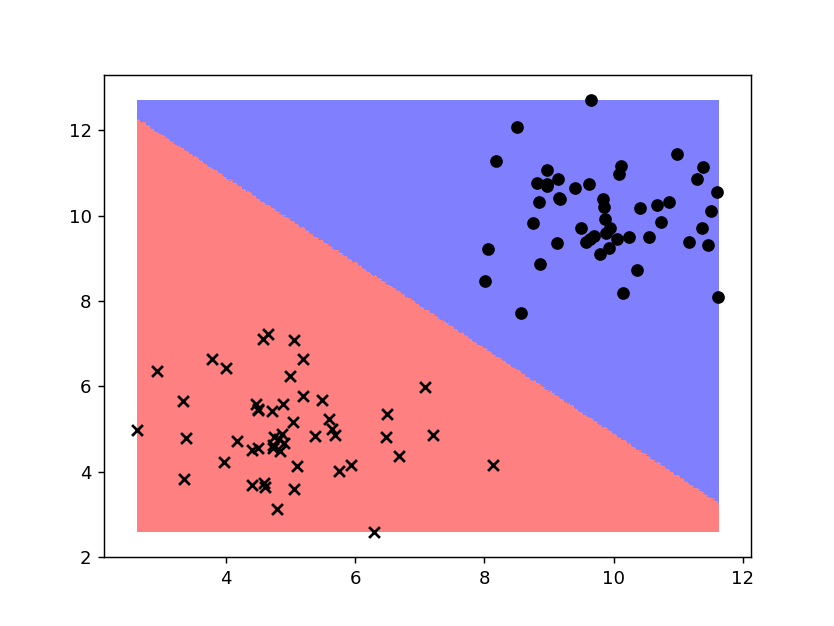

In [16]:
%matplotlib notebook
h.visclassifier(svmclassify, xTr, yTr)

Now, we are going to try another nonlinear dataset.

<IPython.core.display.Javascript object>


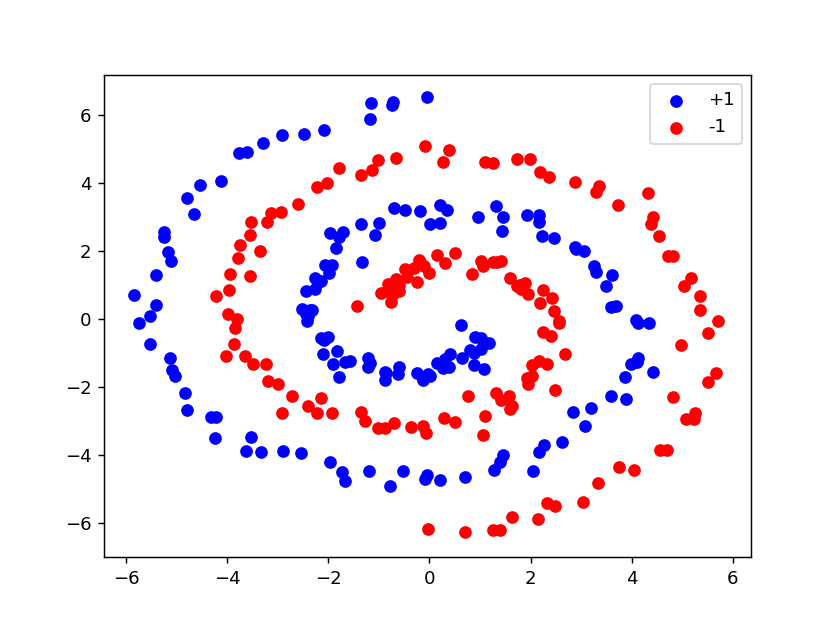

In [10]:
xTr_spiral,yTr_spiral,xTe_spiral,yTe_spiral = h.spiraldata()

%matplotlib notebook
h.visualize_2D(xTr_spiral, yTr_spiral)

Since the dataset is nonlinear, we are going to use the rbf kernel

In [11]:
beta_sol_spiral, bias_sol_spiral, final_loss_spiral = h.minimize(objective=loss, grad=grad, xTr=xTr_spiral, yTr=yTr_spiral, C=100, kerneltype='rbf', kpar=1)
print('The Final Loss of your model is: {:0.4f}'.format(final_loss_spiral))

The Final Loss of your model is: 79.5975


If you do everything correctly, your training error and test error should both be zero!

In [12]:
svmclassify_spiral = lambda x: np.sign(computeK('rbf', xTr_spiral, x, 1).transpose().dot(beta_sol_spiral) + bias_sol_spiral)

predsTr_spiral = svmclassify_spiral(xTr_spiral)
trainingerr_spiral = np.mean(predsTr_spiral != yTr_spiral)
print("Training error: %2.4f" % trainingerr_spiral)

predsTe_spiral = svmclassify_spiral(xTe_spiral)
testerr_spiral = np.mean(predsTe_spiral != yTe_spiral)
print("Test error: %2.4f" % testerr_spiral)

Training error: 0.0000
Test error: 0.0000


Now, let's visualize the classifier!

<IPython.core.display.Javascript object>


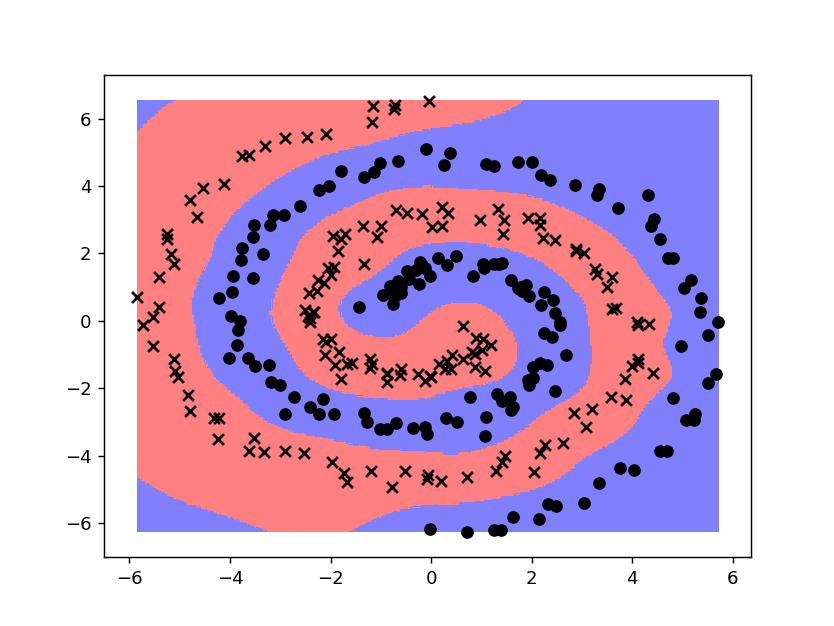

In [13]:
h.visclassifier(svmclassify_spiral, xTr_spiral, yTr_spiral)